In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.models import load_model
import keras.backend as K

import cv2

from skimage.morphology import skeletonize

from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

from patchify import patchify, unpatchify

from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops

2024-01-25 00:14:46.584831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 00:14:46.584906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 00:14:46.586805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 00:14:46.597336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_images(path, type):

    file_list = os.listdir(path)
    images = []

    for filename in file_list:
        if filename.endswith(type):
            input_image_path = os.path.join(path, filename)
            input_image = cv2.imread(input_image_path, 0)
            images.append(input_image)
    
    return images

In [3]:
def roi_image(input_im, offset=10):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    # Adjust width and height to make a perfect square with an offset
    side_length = max(w, h) + 2 * offset
    x = max(0, x - offset)
    y = max(0, y - offset)

    roi = input_im[y:y+side_length, x:x+side_length]
    return roi, y, h, x, w

In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
def padder(image, patch_size):

    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [6]:
def predict_all(images, patch_size):

    predictions = []

    for image in images:
    
        image, _, _, _, _ = roi_image(image)
        image = padder(image, patch_size)
        
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        
        i = patches.shape[0]
        j = patches.shape[1]
        
        patches = patches.reshape(-1, patch_size, patch_size, 1)
        
        preds = model.predict(patches/255)
        
        preds_reshaped = preds.reshape(i, j, patch_size, patch_size)
        
        predicted_mask = unpatchify(preds_reshaped, (i*patch_size, j*patch_size))

        predictions.append(predicted_mask)

    return predictions

In [7]:
def highlight_top_objects(image, prediction, num_objects=5):
    def sort_objects_by_area(stats):
        areas = [stat[-1] for stat in stats[1:]]
        sorted_areas = sorted(enumerate(areas, start=1), key=lambda x: x[1], reverse=True)
        return sorted_areas

    def extract_and_highlight_objects(image, prediction, sorted_areas, num_objects):
        plants = []
        plants_pred = []

        for i in range(1, num_objects + 1):
            index, area = sorted_areas[i - 1]
            x, y, w, h, _ = stats[index]

            cropped_roi_pred = prediction[y:y + h, x:x + w]
            cropped_roi = image[y:y + h, x:x + w]

            plants.append(cropped_roi)
            plants_pred.append(cropped_roi_pred)

            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            prediction = cv2.rectangle(prediction, (x, y), (x + w, y + h), (0, 0, 255), 2)

        return image, prediction, plants, plants_pred

    pred = cv2.convertScaleAbs(prediction)

    _, _, stats, _ = cv2.connectedComponentsWithStats(pred)

    sorted_areas = sort_objects_by_area(stats)

    num_objects = min(num_objects, len(stats) - 1)

    result_image, result_pred, highlighted_plants, highlighted_plants_pred = extract_and_highlight_objects(
        image, prediction, sorted_areas, num_objects
    )

    return result_image, result_pred, highlighted_plants, highlighted_plants_pred

Creating a function, which can convert the cropped images into skeletons, take their summary and then choose the most common skeleton id.

In [8]:
def get_nodes(object):

    skeleton = skeletonize(object>0.3)
    summary = summarize(Skeleton(skeleton))
    summary = summary[summary['skeleton-id'] == 0]

    return summary

Finding the end nodes

In [9]:
def find_end_node(graph):
 
    src = list(graph['node-id-src'])
    end_nodes = []
    for destination in list(graph['node-id-dst']):
        if destination not in src:
            end_nodes.append(destination)
    return end_nodes

Function, which visualizes the nodes by itereting through the starting nodes (junctions) and ending nodes (root tips)

In [10]:
def visualise_landmarks(object, nodes, show_image=True):
    if show_image:
        plt.imshow(object, cmap='gray')

    start_nodes = list(nodes['node-id-src'])
    end_nodes = find_end_node(nodes)

    min_index = nodes['node-id-src'].idxmin()
    min_value_column1 = nodes.loc[min_index, 'image-coord-src-0']
    min_value_column2 = nodes.loc[min_index, 'image-coord-src-1']

    for node in start_nodes:
        node_info = nodes[nodes['node-id-src'] == node]
        x_start, y_start = node_info['image-coord-src-1'], node_info['image-coord-src-0']

        plt.scatter(x_start, y_start, color='blue')

        # Check if any of the points are equal to the minimum index
        if (x_start == min_value_column2).any():
            plt.scatter(min_value_column2, min_value_column1, color='green')

    max_index = nodes['node-id-dst'].idxmax()
    max_value_column1 = nodes.loc[max_index, 'image-coord-dst-0']
    corresponding_value_column2 = nodes.loc[max_index, 'image-coord-dst-1']

    for node in end_nodes:
        node_info = nodes[nodes['node-id-dst'] == node]
        x_end, y_end = node_info['image-coord-dst-1'], node_info['image-coord-dst-0']

        plt.scatter(x_end, y_end, color='red')

        # Check if any of the points are equal to the maximum index
        if (x_end == corresponding_value_column2).any():
            plt.scatter(corresponding_value_column2, max_value_column1, color='black')

    max_coords = (corresponding_value_column2, max_value_column1)

    if show_image:
        plt.show()

    return max_coords

Creating a function similar to the highlight_top_objects, but it takes only the primary root tips

In [11]:
def test_function(image, prediction, num_objects=5):
    def sort_objects_by_area(stats):
        areas = [stat[-1] for stat in stats[1:]]
        sorted_areas = sorted(enumerate(areas, start=1), key=lambda x: x[1], reverse=True)
        return sorted_areas

    def extract_and_highlight_objects(image, prediction, sorted_areas, num_objects):
        plants = []
        plants_pred = []
        all_landmarks = []

        for i in range(1, num_objects + 1):
            index, area = sorted_areas[i - 1]
            x, y, w, h, _ = stats[index]

            cropped_roi_pred = prediction[y:y + h, x:x + w]
            cropped_roi = image[y:y + h, x:x + w]

            nodes = get_nodes(cropped_roi_pred)
            max_coordinates = visualise_landmarks(cropped_roi, nodes, show_image=False)

            x_landmark = max_coordinates[0] + x
            y_landmark = max_coordinates[1] + y

            all_landmarks.append((x_landmark, y_landmark))

        return image, all_landmarks

    pred = cv2.convertScaleAbs(prediction)

    _, _, stats, _ = cv2.connectedComponentsWithStats(pred)

    sorted_areas = sort_objects_by_area(stats)

    num_objects = min(num_objects, len(stats) - 1)

    result_image, all_landmarks = extract_and_highlight_objects(
        image, prediction, sorted_areas, num_objects
    )

    return result_image, all_landmarks

In [12]:
model = load_model('root_model.h5', custom_objects={'f1':f1, 'iou':iou})

2024-01-25 00:15:24.942254: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-25 00:15:25.091627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5902 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-01-25 00:15:25.092159: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-25 00:15:25.201330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1540 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-01-25 00:15:25.201652: W tensorflow/core/common_runti

In [13]:
images = load_images('task_6_images', '.tif')

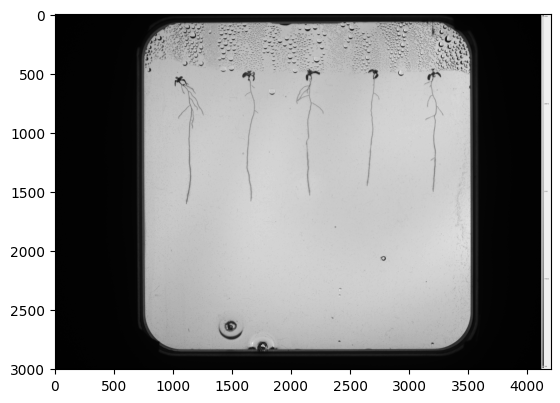

In [14]:
plt.imshow(images[2], cmap='gray')

In [15]:
images[0]

array([[  2,   2,   2, ..., 240, 240, 240],
       [  2,   2,   2, ..., 240, 240, 240],
       [  2,   2,   2, ..., 240, 240, 240],
       ...,
       [  2,   2,   2, ..., 240, 240, 240],
       [  2,   2,   2, ..., 240, 240, 240],
       [  1,   2,   2, ..., 240, 240, 240]], dtype=uint8)

In [16]:
predictions = predict_all(images, 256)

2024-01-25 00:15:33.790692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


4/4 [==============================] - 2s 30ms/step


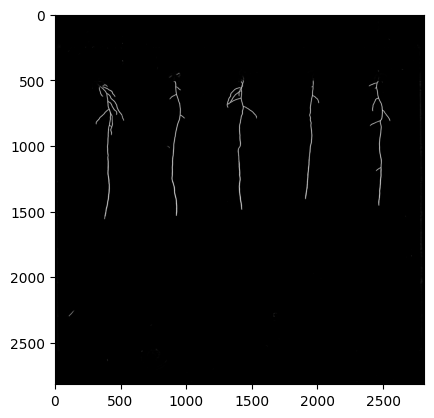

In [17]:
plt.imshow(predictions[2], cmap='gray')

In [18]:
roi_images = []

for image in images:
    new_im, _, _, _, _ = roi_image(image)
    roi_images.append(new_im)

In [19]:
test_image = roi_images[2]

In [20]:
test_image = padder(test_image, 256)

In [21]:
test_pred = predictions[2]

In [22]:
test_image, test_pred, plants, plants_pred = highlight_top_objects(test_image, test_pred)

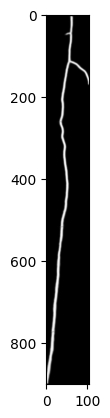

In [23]:
plt.imshow(plants_pred[4], cmap='gray')

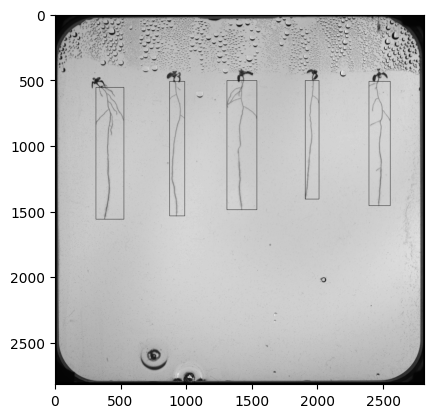

In [24]:
plt.imshow(test_image, cmap='gray')

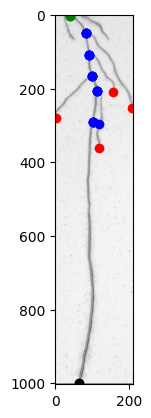

(65, 1000)


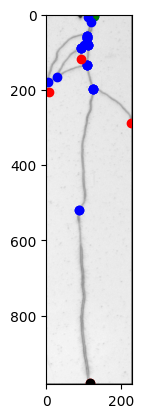

(115, 980)


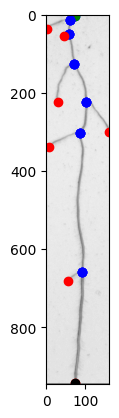

(74, 942)


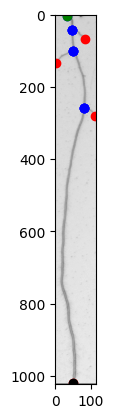

(50, 1020)


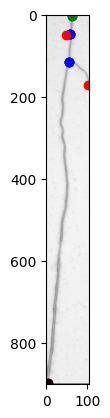

(3, 899)


In [25]:
checker = []

for plant_pred, plant in zip(plants_pred, plants):
    nodes = get_nodes(plant_pred)
    checker.append(nodes)
    max_coordinates = visualise_landmarks(plant, nodes)
    print(max_coordinates)

In [26]:
checker[1]

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,33,20.899495,1,1.0,0.0,2,126,20,119,2,126,20,119,19.313208
1,0,5,33,18.313708,1,1.0,0.0,7,111,20,119,7,111,20,119,15.264338
2,0,33,86,39.727922,2,1.0,0.0,20,119,55,109,20,119,55,109,36.400549
3,0,86,600,190.823376,2,1.0,0.0,55,109,178,5,55,109,178,5,161.074517
4,0,86,113,6.000000,2,1.0,0.0,55,109,61,109,55,109,61,109,6.000000
5,0,113,176,24.313708,2,1.0,0.0,61,109,80,99,61,109,80,99,21.470911
6,0,113,173,19.242641,2,1.0,0.0,61,109,79,110,61,109,79,110,18.027756
7,0,173,176,11.414214,2,1.0,0.0,79,110,80,99,79,110,80,99,11.045361
8,0,173,390,57.485281,2,1.0,0.0,79,110,134,108,79,110,134,108,55.036352
9,0,176,214,12.485281,2,1.0,0.0,80,99,89,92,80,99,89,92,11.401754


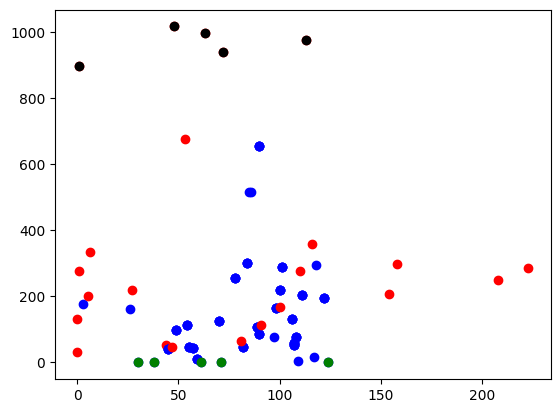

In [27]:
image_landmarks, landmarks = test_function(test_image, test_pred)

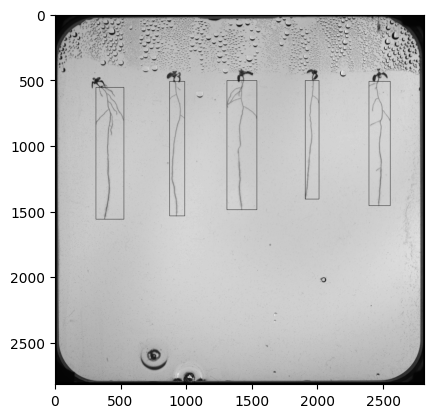

In [28]:
plt.imshow(image_landmarks, cmap='gray')

In [29]:
landmarks

[(376, 1558), (1423, 1486), (2463, 1454), (922, 1532), (1907, 1405)]

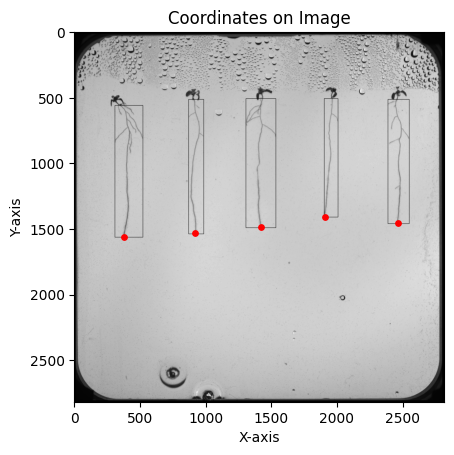

In [30]:
x_values, y_values = zip(*landmarks)

# Plotting
plt.imshow(image_landmarks, cmap='gray')
plt.scatter(x_values, y_values, color='red', marker='o', s=15)  # Adjust 's' for marker size
plt.title('Coordinates on Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()